In [3]:
!python /home/chen/chengxu/LSHVec-master/process/fastatoseq.py -i /home/chen/chengxu/LSHVec-master/new_data_500/merged1.fasta -o /home/chen/chengxu/LSHVec-master/new_data_500/test.seq

In [4]:
!head -n 3 /home/chen/chengxu/LSHVec-master/new_data_500/test.seq

1	1200300_Archaea_db	ATCAAGAAGGCCAAACAGTACCACAAGATATGCCCCTACTTCGACAAGAGAACTAAGATGTGCTTCCTGACCCTCGGGCAGAAGTGCGACAGGGAGGGCAAGTTCGACGTGTGCCCGGTGTTCAAGTCATTCCTCGAGAAGAAGTACGACGAGTTCAAGGCCAAAAACCTCCCACTACCACTAGACTTCGCCGACCTAGTGGCCTCGCCGTTGTAGGCGGTGTTGAGCGCATGTCTGTCAAAGAGTACAGGGTGAGAGACCTAGACAAGGTGTGGTTTGAGTACGACAAACAGAACGACATACTCTACATAAACTTCGGCGACTCCACCGAGGAGGCTGACGAGGAGTTTCTAAGCGAAAACGGCGACGTCGCGTTCAGGATCAAGGAGGGTCGCATCATATCCATAATGATAATCGGCCTGAGCACCAAAGCAGGTTTCACTGTTCTTTAGCCCGAGGGTGTCAGGCCTCTAGTTAAGGACGCTACTCGGGTACAGCTTTCTCGCTCACCTCAGGTGGGCGGAGTTTTTCGTCGAACACTACCTTTAACAGGCCCAGCTTTTTCAAGACCAAGTTTACGTAGTCGGTGATCACGTTCCTGTCAAACCCCATTTTTTCAGCCCTATTCAAGACTATGTTCTCCACGACGCTGTACTTACCGTACTTCTCGTTCAGGTCTTTCCAGGGTATACCGGTCATAGCCTTGATTACCTCGTTGTCCACCGGTAGAATGCCCTTCACCATCATGAAGGCTATGATGGGGTAGCCCACGTACCCTTTGAACACAGTACCGTTGTCGTTGCTGTAGACCCTGTACGAGTTCTCTCCGTCCTTGACTACGACCACTATGTACTCCTTTTCGCCCCTGCTCGATGTGATCTTGGCCGTGTTCTCGTCTACGAGCTTTATTCTCGCGTCACCTATACTCCCAGCAGCCTCTAACACCTTAATCCTAGGGGGCCTAGTCAGGACCTTCAAG

In [5]:
!python /home/chen/chengxu/LSHVec-master/scripts/fastseq/hashSeq.py -i /home/chen/chengxu/LSHVec-master/new_data_500/test.seq --hash lsh -o /home/chen/chengxu/LSHVec-master/new_data_500/out/test.fnv -k 15 --hash_size 25 --bucket 67108864

2023-08-07 20:45:24,814 - hashSeq - INFO - start converting...
2023-08-07 20:45:24,814 - hashSeq - INFO - parameters: {'in_file': '/home/chen/chengxu/LSHVec-master/new_data_500/test.seq', 'out_file': '/home/chen/chengxu/LSHVec-master/new_data_500/out/test.fnv', 'hash_size': 25, 'batch_size': 100000, 'create_lsh_only': False, 'lsh_file': '', 'f': <function convert.<locals>.f at 0x7f1a19136598>, 'bucket': 67108864, 'hash_fun': 'lsh', 'kmer_size': 15, 'n_thread': 3}
2023-08-07 20:45:24,814 - hashSeq - INFO - creating hash ...
100%|███████████████████████████████████████| 750/750 [00:00<00:00, 1629.31it/s]
2023-08-07 20:45:25,364 - hashSeq - INFO - finish creating hash ...
100%|██████████████████████████████████████| 2000/2000 [00:18<00:00, 110.19it/s]
2023-08-07 20:45:45,575 - hashSeq - INFO - written 2000 lines
2023-08-07 20:45:45,575 - hashSeq - INFO - finish converting...


In [6]:
import numpy as np
def read_embedding(fname):
    with open(fname) as fin:
        lines=list(fin)
    assert len(lines)>1
    first_line=lines[0]
    num_word, dim_vec = [int(u) for u in first_line.split(" ")]
    assert len(lines)==num_word+1
    ret ={}
    for line in lines[1:]:
        lst = line.strip().split(" ")
        assert len(lst)==dim_vec+1, line
        if lst[0]=='</s>': continue
        word = int(lst[0])
        vec = np.array([float(u) for u in lst[1:]])
        ret[word]=vec
    return ret,dim_vec
embedding,dim_vec = read_embedding("/home/chen/chengxu/LSHVec-master/new_data_500/embedding/testnew.vec")
seqvectors = []
with open("/home/chen/chengxu/LSHVec-master/new_data_500/out/test.fnv") as fin:
    lines = list(fin)
for i,line in enumerate(lines):
    words = [int(u) for u in line.strip().split(" ")]
    vec = [embedding[u] for u in words if u in embedding]
    seqvectors.append(np.mean(vec,0) if len(vec)>0 else None)

In [7]:
import pandas as pd
seqs = pd.read_csv("/home/chen/chengxu/LSHVec-master/new_data_500/test.seq",sep='\t', header=None, usecols=[0,1],index_col=0)
seqs.columns=['id']
seqs['special'] = seqs['id'].apply(lambda x: x.split("_")[1])
seqs['vec']=seqvectors
seqs.head()

,id,special,vec
0,,,
1,1200300_Archaea_db,Archaea,"[0.09203570074968233, -0.1427766776874204, 0.0..."
2,84156_Archaea_db,Archaea,"[0.08806425631516586, -0.18062056419431294, 0...."
3,1937004_Archaea_db,Archaea,"[0.024726943376963392, -0.1263500343717277, 0...."
4,83816_Archaea_db,Archaea,"[0.17004447937824466, -0.12865353970333743, 0...."
5,2508726_Archaea_db,Archaea,"[0.14470140506082732, -0.14739097258029205, 0...."


CPU times: user 25.7 s, sys: 11.7 s, total: 37.4 s
Wall time: 9.64 s
['Archaea', 'Bacteria', 'Viruses', 'Eukaryota']


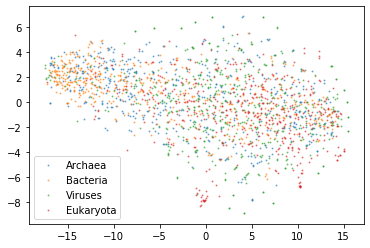

In [9]:
import matplotlib.pyplot as plt
from MulticoreTSNE import MulticoreTSNE as TSNE
#seqss=seqs.sample(5000,replace=False)
tsne = TSNE(n_components=2, perplexity=100, n_jobs=8)
X=np.array(list(seqs['vec'].values))
X.shape
%time Y = tsne.fit_transform(X)
labels=seqs['special'].values
legends=list(set(labels))
print (legends)
for label in legends:
    plt.scatter(Y[labels==label][:,0],Y[labels==label][:,1],alpha=0.5,s=1)
plt.legend(legends)
